Converged in 16662 iterations.


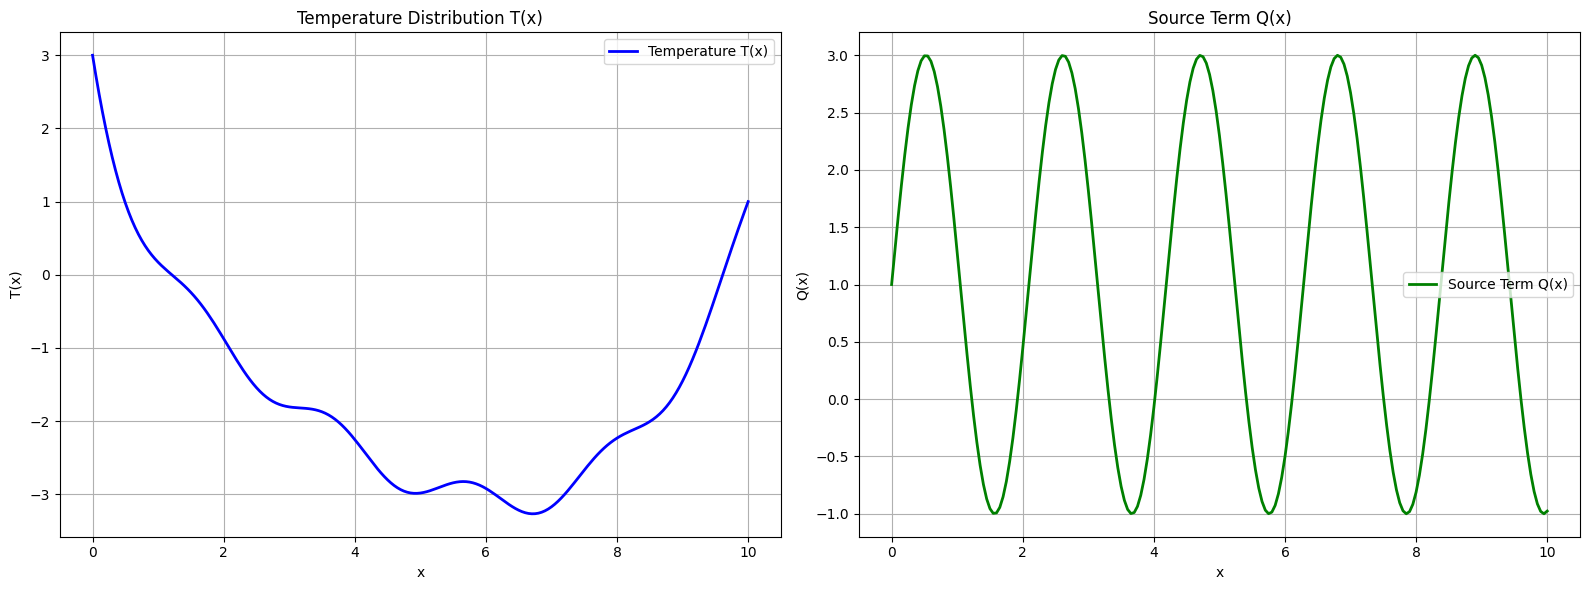

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def FDM(Lx, N, EPS, b1, W1, max_iter):
    """
    Solves a second-order ODE using the Finite Difference Method (FDM).

    Parameters:
        Lx (float): Length of the domain.
        N (int): Number of spatial intervals.
        EPS (float): Convergence criterion.
        b1 (float): Parameter for a(x).
        W1 (float): Parameter for Q(x).
        max_iter (int): Maximum number of iterations.

    Returns:
        x_vals (np.ndarray): Spatial grid points.
        T_new (np.ndarray): Temperature distribution.
        Q (np.ndarray): Source term Q(x).
    """
    dx = Lx / N
    x_vals = np.linspace(0, Lx, N + 1)

    a = (b1 + x_vals) / (1.0 + x_vals**2)
    Q = 1.0 + b1 * np.sin(W1 * x_vals)

    T_new = np.ones(N + 1)
    T_new[0], T_new[-1] = 3.0, 1.0

    for k in range(max_iter):
        T_old = T_new.copy()

        for i in range(1, N):
            T_new[i] = (T_old[i - 1] + T_old[i + 1] - Q[i] * dx**2) / (2.0 + a[i] * dx**2)

        if np.max(np.abs(T_new - T_old)) < EPS:
            print(f"Converged in {k + 1} iterations.")
            break
    else:
        print("Maximum iterations reached without convergence.")

    return x_vals, T_new, Q, a

def fdm_solution(x_vals, T):
    """
    Creates an exact solution function by interpolating the numerical solution.

    Parameters:
        x_vals (np.ndarray): Spatial grid points.
        T (np.ndarray): Temperature distribution.

    Returns:
        callable: Function to evaluate the solution at arbitrary points.
    """
    f_interp = interp1d(x_vals, T, kind='cubic', fill_value="extrapolate")
    return lambda x: f_interp(x)

def plot_results(x_vals, T, Q):
    """
    Plots the temperature distribution and source term.

    Parameters:
        x_vals (np.ndarray): Spatial grid points.
        T (np.ndarray): Temperature distribution.
        Q (np.ndarray): Source term Q(x).
    """
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    axs[0].plot(x_vals, T, color='blue', linewidth=2, label="Temperature T(x)")
    axs[0].set_title('Temperature Distribution T(x)')
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('T(x)')
    axs[0].grid(True)
    axs[0].legend()

    axs[1].plot(x_vals, Q, color='green', linewidth=2, label="Source Term Q(x)")
    axs[1].set_title('Source Term Q(x)')
    axs[1].set_xlabel('x')
    axs[1].set_ylabel('Q(x)')
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    Lx = 10.0
    N = 200
    EPS = 1e-6
    b1 = 2.0
    W1 = 3.0
    max_iter = 100000

    x_vals, T, Q, a = FDM(Lx, N, EPS, b1, W1, max_iter)
    fdm_solution = fdm_solution(x_vals, T)
    plot_results(x_vals, T, Q)

Using device: cuda
4382.326171875
Epoch 0: Loss = 4382.326172


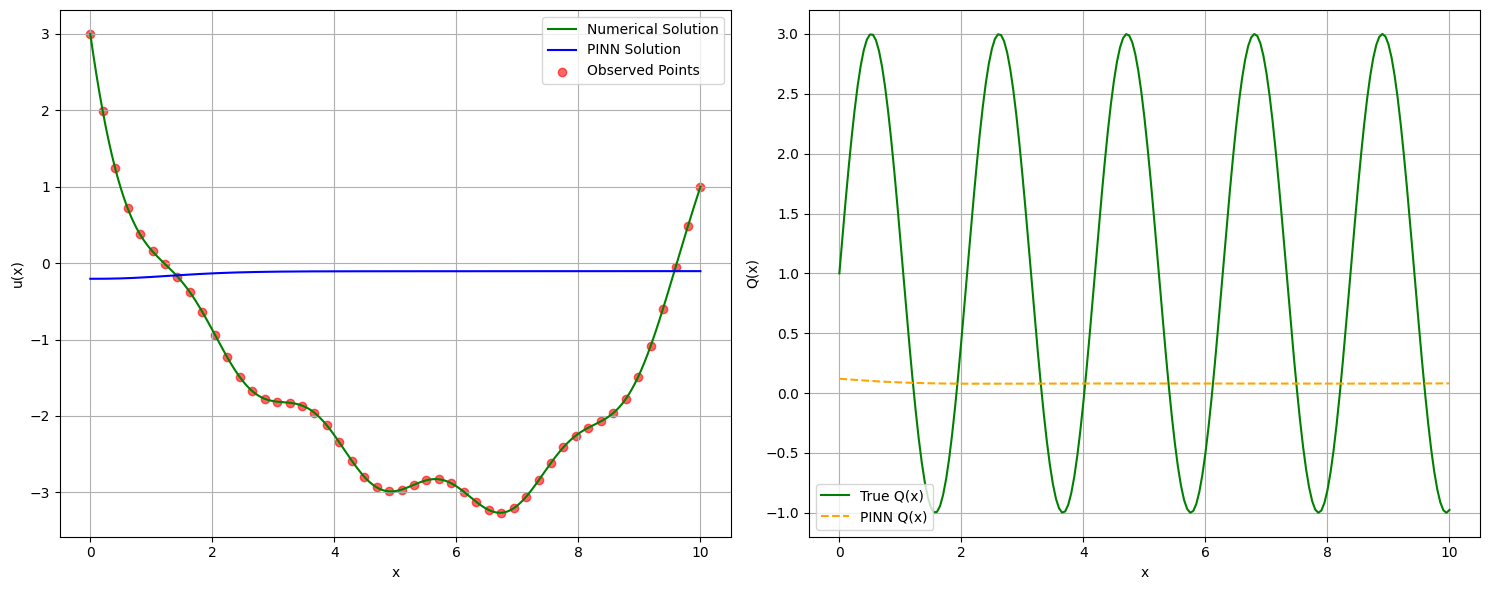

359.2051696777344
51.66915512084961
26.480552673339844
20.309404373168945
18.306148529052734
16.95602035522461
15.217623710632324
13.118661880493164
11.303847312927246
8.391960144042969
Epoch 10000: Loss = 8.391960


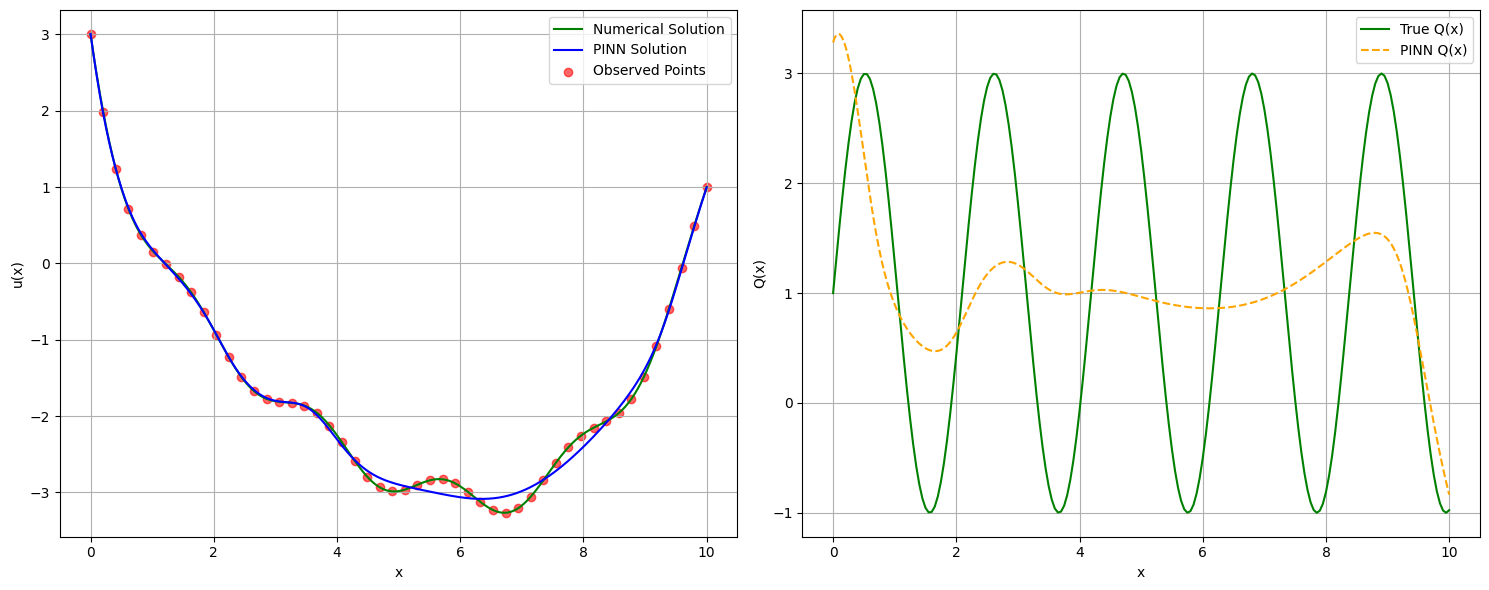

1.915912389755249
1.1714980602264404
0.8805660605430603
0.6449230909347534
0.4538339376449585
0.30639705061912537
0.18814286589622498
0.10074356198310852
0.11081541329622269
0.02244311198592186
Epoch 20000: Loss = 0.022443


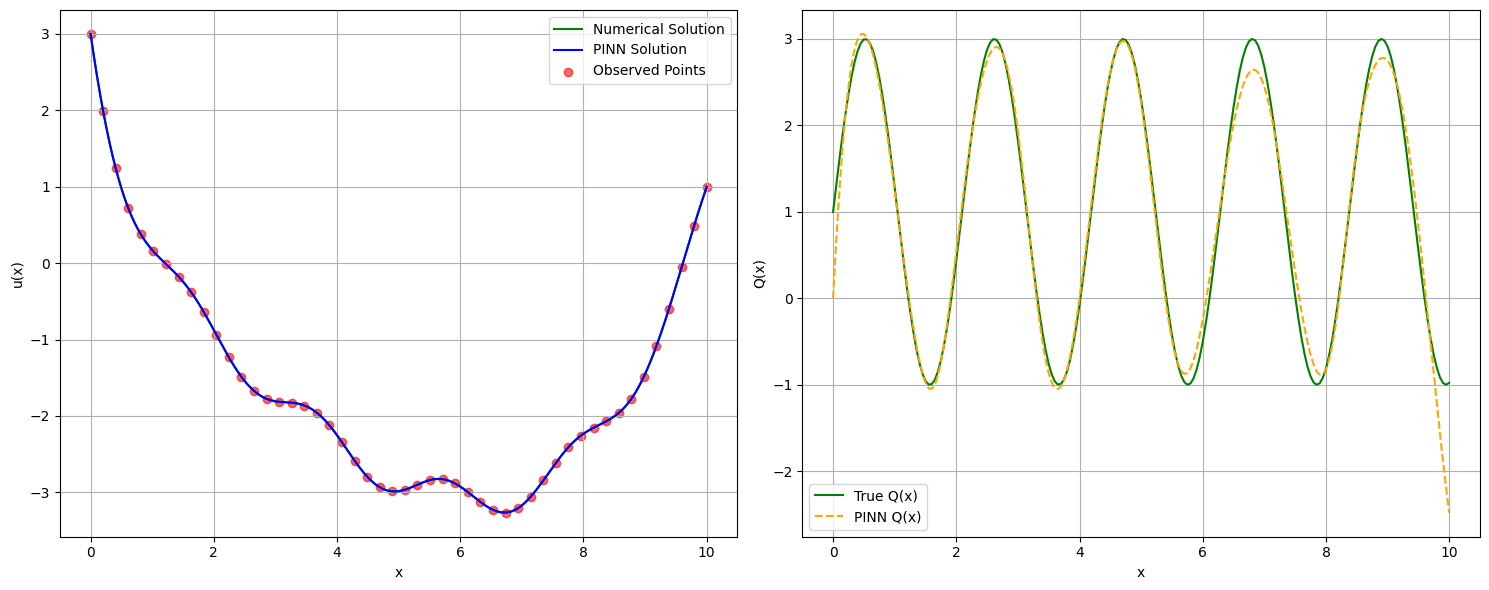

0.012069311924278736
0.008215771988034248
0.007179676089435816
0.005387713201344013
0.004703030455857515
0.004218336660414934
0.003862775629386306
0.0035601602867245674
0.0033234781585633755
0.0030830823816359043
Epoch 30000: Loss = 0.003083


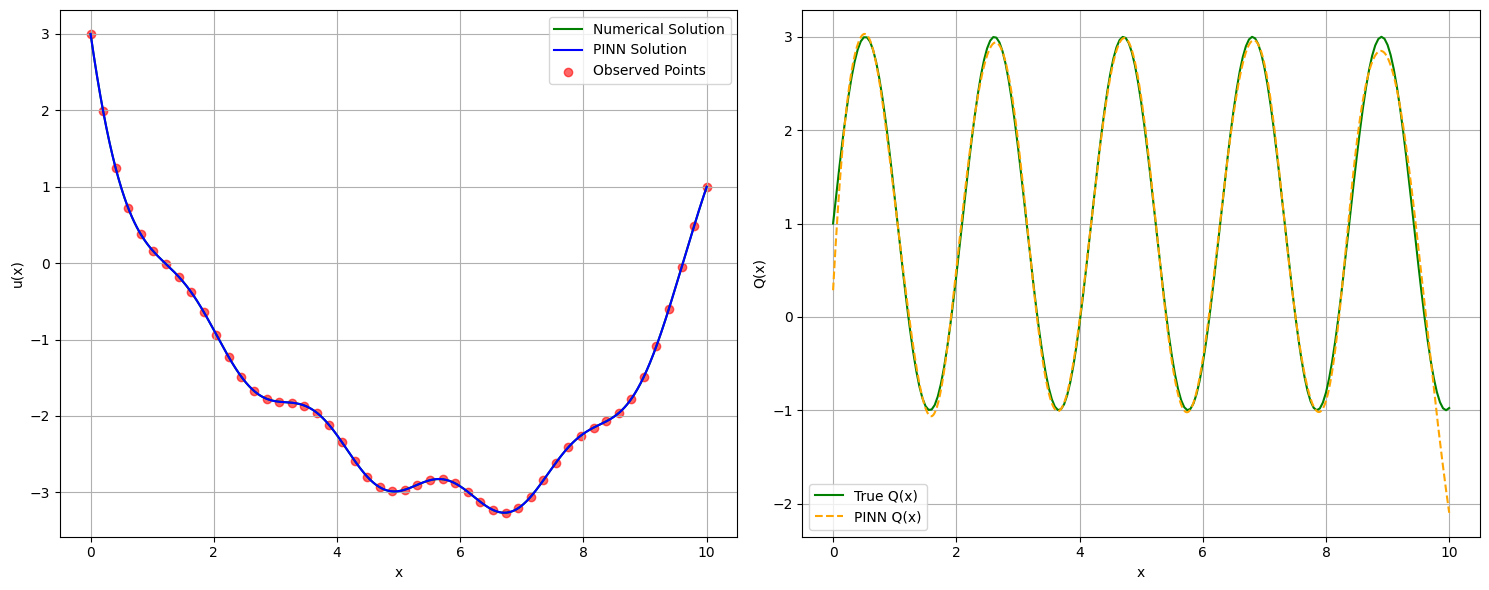

0.0029007969424128532
0.0027264016680419445
0.002575766295194626
0.002441819291561842
0.037462856620550156
0.002213316038250923
0.002116074552759528
0.046994127333164215
0.0019453371642157435
0.0018685134127736092
Epoch 40000: Loss = 0.001869


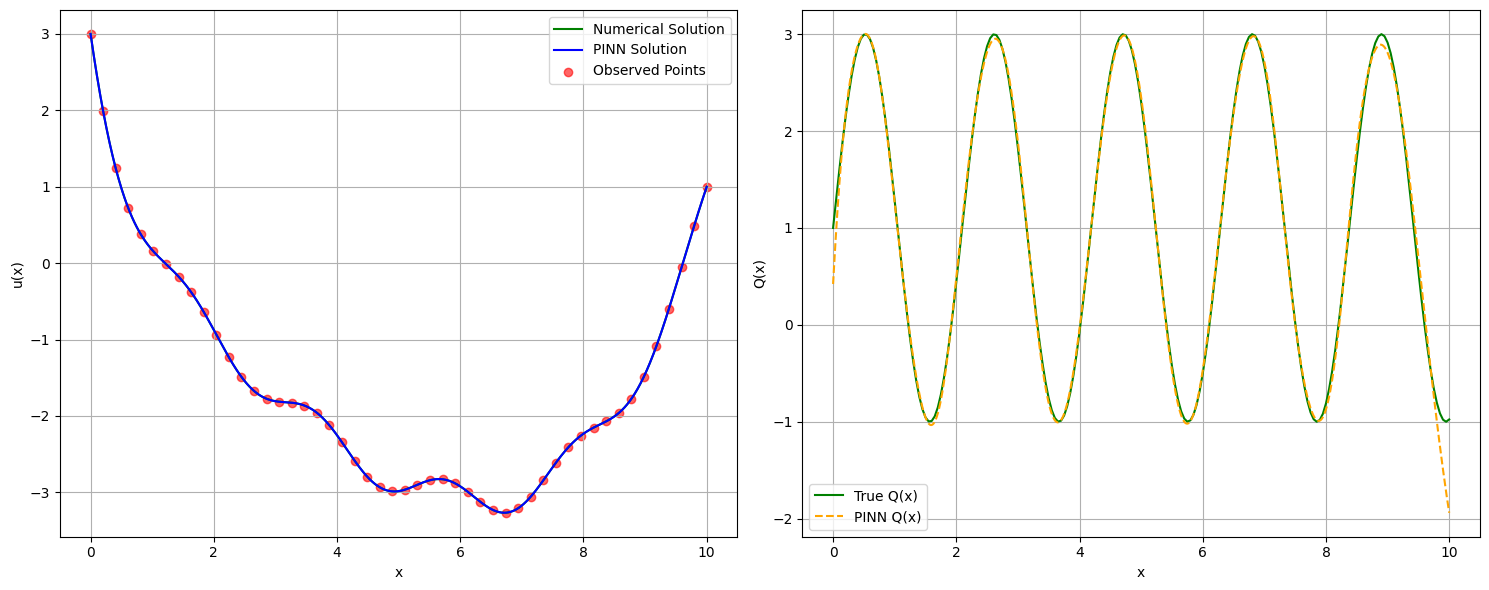

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import numpy as np
import random
import os

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(123)
np.random.seed(123)
random.seed(123)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

class PINN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x):
        return self.model(x)

Lx = 10
x_physics = torch.linspace(0, Lx, 1000).view(-1, 1).requires_grad_(True).to(device)  # Move to GPU if available
x_obs = torch.linspace(0, Lx, 50).view(-1, 1).to(device)  # Move to GPU if available
u_obs = torch.tensor(fdm_solution(x_obs.detach().cpu().numpy()), dtype=torch.float32).view(-1, 1).to(device)

a_interp = interp1d(x_vals, a, kind="cubic", fill_value="extrapolate")
a_tensor = torch.tensor(a_interp(x_physics.detach().cpu().numpy()), dtype=torch.float32).to(device)

# PINN model
pinn = PINN(1, 2, 70).to(device)  # Increased hidden dimensions
optimizer = optim.Adam(pinn.parameters(), lr=1e-4)  # Adjusted learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.5)

# Loss weights and normalization factors
lambda_data = 1e3  # Reduced weight for data loss
losses = []

for epoch in range(40001):
    optimizer.zero_grad()
    predictions = pinn(x_physics)
    u_pred, Q_pred = predictions[:, 0:1], predictions[:, 1:2]

    dudx = torch.autograd.grad(u_pred, x_physics, torch.ones_like(u_pred), create_graph=True)[0]
    d2udx2 = torch.autograd.grad(dudx, x_physics, torch.ones_like(dudx), create_graph=True)[0]
    residual = d2udx2 - a_tensor * u_pred - Q_pred
    loss_physics = torch.mean(residual**2)

    u_obs_pred = pinn(x_obs)[:, 0:1]
    loss_data = torch.mean((u_obs_pred - u_obs)**2)

    loss = loss_physics + lambda_data * loss_data
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    if epoch % 1000 == 0:
      print(loss.item())
    if epoch % 10000 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")
        with torch.no_grad():
            test_predictions = pinn(x_physics)
            u_test, Q_test = test_predictions[:, 0:1].detach().cpu().numpy(), test_predictions[:, 1:2].detach().cpu().numpy()

        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        axes[0].plot(x_physics.detach().cpu().numpy(), fdm_solution(x_physics.detach().cpu().numpy()), label="Numerical Solution", color="green")
        axes[0].plot(x_physics.detach().cpu().numpy(), u_test, label="PINN Solution", color="blue")
        axes[0].scatter(x_obs.cpu().numpy(), u_obs.cpu().numpy(), label="Observed Points", color="red", alpha=0.6)
        axes[0].set_xlabel("x")
        axes[0].set_ylabel("u(x)")
        axes[0].legend()
        axes[0].grid(True)

        axes[1].plot(x_vals, Q, label="True Q(x)", color="green")
        axes[1].plot(x_physics.detach().cpu().numpy(), Q_test, label="PINN Q(x)", color="orange", linestyle='--')
        axes[1].set_xlabel("x")
        axes[1].set_ylabel("Q(x)")
        axes[1].legend()
        axes[1].grid(True)

        os.makedirs("images", exist_ok=True)
        plt.savefig("images/pinn_forward_inverse.png")
        plt.tight_layout()
        plt.show()